# FigS5d - Fluorescence Intensity Analysis

## Overview
This notebook processes two-channel microscopy images (Membrane and FtsZ signals) to:
- Load straightened `.tif` images for each channel.
- Compute intensity projections along the cell axis.
- Normalize and optionally smooth the intensity profiles.
- Plot the profiles with clear labeling for cell poles and equator.
- Save both the plot (`.svg`) and numerical data (`.csv`) for further analysis or publication.

---

## Input Requirements
- **Image files**: Two `.tif` images from the same field of view, already straightened:
  1. **Membrane channel** 
  2. **FtsZ channel**
- **Python environment** with:
  - `numpy`
  - `matplotlib`
  - `Pillow`
  - `scipy`
  - `opencv-python` *(imported but optional)*
- Paths to these files must be specified before running the analysis.

---

## Outputs
1. **SVG plot** showing normalized intensity profiles:
   - Membrane: purple curve
   - FtsZ<sup>MTS</sup>: green curve
   - X-axis labeled as “Pole 1 – Equator – Pole 2”
2. **CSV file** containing:
   - Raw intensity values for both channels
   - Normalized intensity values for both channels
   - Empty column for separation between raw and normalized data

---

## How to Run
### 1. Set paths:
   - In the section defining:
     ```python
     path_membrane = "path/to/membrane_image.tif" : path to the membrane channel folder
     path_ftsz = "path/to/ftsz_image.tif" : path to the ftsz channel folder
     svg_output_path = "path/to/output/Fig4d.svg" : path to save the output plot
     csv_output_path = "path/to/output/Fig4d_data.csv" : path to save the numerical results
     ```

### 2. Configure analysis parameters:
   - **apply_smoothing**: `True` or `False`  
   - **smoothing_factor**: e.g., `300`

### 3. Run all cells in order:
   - Ensure dependencies are installed.
   - Execute each cell from top to bottom without skipping.

### 4. Check output files in the specified directory.
   - Open the `.svg` to verify the plot.
   - Open the `.csv` to inspect numerical values.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os
from scipy.interpolate import make_interp_spline
from pathlib import Path

# Set matplotlib style for minimal design
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = False

In [2]:
# Set Straighten image paths
path_membrane = Path('02_FigS5c_straightener_output/ACA-5-m_c1_membrane_straight.tif')
path_ftsz = Path('02_FigS5c_straightener_output/ACA-5-g_c2_FtsZ_straight.tif')

# Set output file paths
svg_output_path = Path('04_FigS5d_plot_output/FigS5d.svg')
csv_output_path = Path('04_FigS5d_plot_output/FigS5d.csv')

In [3]:
def load_single_image(image_path):
    img = Image.open(image_path)
    frame = np.array(img.convert('L'))
    return frame

def calculate_projections(roi, axis=0):
    projection_raw = np.sum(roi, axis=axis).astype(np.float32)
    
    # 0-max normalization
    projection_normalized = projection_raw.copy()
    max_val = projection_raw.max()
    if max_val > 0:
        projection_normalized = projection_normalized / max_val
    
    return projection_raw, projection_normalized

def smooth_data(x, y, smoothing_factor=300):
    if smoothing_factor <= len(x):
        smoothing_factor = len(x) * 2
    
    x_smooth = np.linspace(x.min(), x.max(), smoothing_factor)
    spl = make_interp_spline(x, y, k=3)  # cubic spline
    y_smooth = spl(x_smooth)
    
    return x_smooth, y_smooth

In [4]:
def analyze_two_channel_images(path_membrane, path_ftsz, apply_smoothing=True, smoothing_factor=300, save_path=None):
    
    # Load images
    image_membrane = load_single_image(path_membrane)
    image_ftsz = load_single_image(path_ftsz)
    
    print(f"Membrane image shape: {image_membrane.shape}")
    print(f"FtsZ image shape: {image_ftsz.shape}")
    
    # Calculate both raw and normalized projections
    projection_membrane_raw, projection_membrane = calculate_projections(image_membrane, axis=0)
    projection_ftsz_raw, projection_ftsz = calculate_projections(image_ftsz, axis=0)
    
    # Create x-axis (pixel positions)
    x = np.arange(len(projection_membrane))
    
    # Create plot with minimal style
    fig, ax = plt.subplots(figsize=(8, 4))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    if apply_smoothing:
        # Apply smoothing
        x_smooth_membrane, y_smooth_membrane = smooth_data(x, projection_membrane, smoothing_factor)
        x_smooth_ftsz, y_smooth_ftsz = smooth_data(x, projection_ftsz, smoothing_factor)
        
        # Plot smoothed curves with new colors
        ax.plot(x_smooth_membrane, y_smooth_membrane, label='Membrane', color='#B200F4', linewidth=2)
        ax.plot(x_smooth_ftsz, y_smooth_ftsz, label=r'$\mathrm{FtsZ^{MTS}}$', color='#00C000', linewidth=2)
    else:
        # Plot original data
        ax.plot(x, projection_membrane, label='Membrane', color='#B200F4', linewidth=2)
        ax.plot(x, projection_ftsz, label=r'$\mathrm{FtsZ^{MTS}}$', color='#00C000', linewidth=2)
    
    # Set x-axis limits to match original data range
    ax.set_xlim(0, len(x) - 1)
    
    # Set y-axis limits to start from 0
    ax.set_ylim(0, None) 
    
    # Set custom x-axis ticks
    first_point = 0
    middle_point = len(x) // 2
    last_point = len(x) - 1
    
    ax.set_xticks([first_point, middle_point, last_point])
    ax.set_xticklabels(['Pole 1', 'Equator', 'Pole 2'])
    
    # Styling with bold axes and larger tick labels
    ax.set_ylabel('Normalized Intensity', fontsize=14)
    ax.legend(loc='upper right', frameon=False, fontsize=10)
    
    # Make tick marks bolder and longer
    ax.tick_params(axis='x', labelsize=14, width=2, length=8)
    ax.tick_params(axis='y', labelsize=14, width=2, length=8)
    
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        # Create directory if needed
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()
    
    return projection_membrane_raw, projection_membrane, projection_ftsz_raw, projection_ftsz

In [5]:
def save_projections_to_csv(projection_membrane_raw, projection_ftsz_raw, projection_membrane, projection_ftsz, save_path):
    # Create data list manually to handle the empty column
    data_rows = []
    
    for i in range(len(projection_membrane_raw)):
        row = [
            f"{projection_membrane_raw[i]:.5f}",
            f"{projection_ftsz_raw[i]:.5f}",
            "",  # empty column
            f"{projection_membrane[i]:.5f}",
            f"{projection_ftsz[i]:.5f}"
        ]
        data_rows.append(row)
    
    # Write to CSV
    with open(save_path, 'w') as f:
        # Write header
        f.write("Membrane_raw,FtsZ_raw,,Membrane_normalized,FtsZ_normalized\n")
        # Write data rows
        for row in data_rows:
            f.write(",".join(row) + "\n")
    
    print(f"CSV saved to: {save_path}")

Membrane image shape: (7, 84)
FtsZ image shape: (7, 84)
Plot saved to: /Users/jyzerresico/chenlab/Protocell Division Data Analysis/FigS5d/04_FigS5d_plot_output/FigS5d.svg


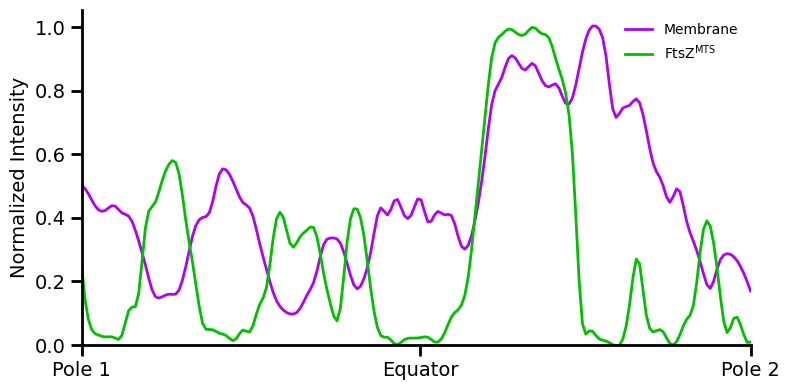

CSV saved to: /Users/jyzerresico/chenlab/Protocell Division Data Analysis/FigS5d/04_FigS5d_plot_output/FigS5d.csv


In [7]:
# Analyze images with smoothing
proj_membrane_raw, proj_membrane, proj_ftsz_raw, proj_ftsz = analyze_two_channel_images(
    path_membrane, 
    path_ftsz, 
    apply_smoothing=True, 
    smoothing_factor=200,  # Adjust this for more/less smoothing
    save_path=svg_output_path
)
save_projections_to_csv(proj_membrane_raw, proj_ftsz_raw, proj_membrane, proj_ftsz, csv_output_path)